<a href="https://colab.research.google.com/github/assermahmoud99/Sentiment-Analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Instantiating the setup

In this section, All the required libraries got imported:

*   pandas for data handling.

*   scikit-learn for splitting data, vectorization, training Logistic Regression, and evaluation.

*   spaCy for advanced text preprocessing (lemmatization, stopword removal).
*   NLTK’s VADER sentiment analyzer for lexicon-based sentiment detection.


*   Loaded the dataset
*   Instantiated the sentiment analyser







In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download("vader_lexicon") #downloading sentiment analysis model
df = pd.read_csv('amazon.csv') #extracting the data
sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


sentiment
1.0    1396
0.0      68
Name: count, dtype: int64
vader_sentiment
1    1384
0      80
Name: count, dtype: int64


# 2. Data sentiment

Here I created two sentiment labels:



1.   Rating-based (sentiment) → derived from star ratings (>3.5 = positive, <3.6 = negative).
2.   VADER-based (vader_sentiment) → generated from the review text using VADER (compound ≥ 0 = positive, else negative).

The main issue is that the dataset’s ratings are heavily skewed toward positive, making them unreliable for sentiment analysis. VADER helps by producing sentiment directly from the text, giving a more balanced variations within the data.




In [ ]:
df["review_text"] = df["review_title"].fillna("") + " " + df["review_content"].fillna("")
def vader_sentiment(text):
    score = sia.polarity_scores(str(text))["compound"]
    if score >= 0:
        return 1
    else:
        return 0

def sentiment_score(rating):
  if rating > 3.5:
    return 1
  elif rating < 3.6 :
    return 0
  else :
    return None
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df["vader_sentiment"] = df["review_content"].apply(vader_sentiment)
df['sentiment'] = df['rating'].apply(sentiment_score)
df = df.dropna(subset=['sentiment'])
df = df.dropna(subset=['vader_sentiment'])
print(df['sentiment'].value_counts())
print(df['vader_sentiment'].values)

sentiment
1    1396
0      68
Name: count, dtype: int64
[1 1 1 ... 1 0 1]


# 3. Text Cleaning with spaCy

I clean the reviews using spaCy:

*   Keep only alphabetic tokens.
*   Remove stopwords (e.g., the, is).

*   Lemmatize words (e.g., running → run).
*   Convert to lowercase.



This reduces noise and ensures the text is in a consistent form before vectorization.

In [ ]:

nlp = spacy.load('en_core_web_sm')
tokens = []
def clean_text(review):
  doc = nlp(review)
  for token in doc:
    if token.is_alpha and not token.is_stop:
      tokens.append(token.lemma_.lower())
  return " ".join(tokens)
df['review_text'] = df['review_text'].astype(str).apply(clean_text)
df['review_text'].head(10)


,review_text
0,satisfy charging fast value money product revi...
1,satisfy charging fast value money product revi...
2,satisfy charging fast value money product revi...
3,satisfy charging fast value money product revi...
4,satisfy charging fast value money product revi...
5,satisfy charging fast value money product revi...
6,satisfy charging fast value money product revi...
7,satisfy charging fast value money product revi...
8,satisfy charging fast value money product revi...
9,satisfy charging fast value money product revi...


# 4. Logistic Regression with Rating Labels
This trains a Logistic Regression classifier using rating-based sentiment labels as the target.

Reviews are converted into numerical features with TF-IDF.

The model is trained and evaluated with accuracy, confusion matrix, precision, recall, and F1.

Because the dataset is heavily skewed toward positive ratings, results reflect the imbalance problem.

In [ ]:
X = df['review_text']
y = df['sentiment']
X_train , X_test , y_train , y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
vecotrizer = TfidfVectorizer(stop_words='english')
X_train_vec = vecotrizer.fit_transform(X_train)
X_test_vec = vecotrizer.transform(X_test)
lr = LogisticRegression()
lr.fit(X_train_vec, y_train)
y_pred = lr.predict(X_test_vec)
print(lr.coef_)
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[-8.67293263e-04 -9.44070610e-05  1.17836855e-04 ... -1.09186630e-04
  -1.09186630e-04 -1.09186630e-04]]
[[  0  14]
 [  0 279]]
0.9522184300341296
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.95      1.00      0.98       279

    accuracy                           0.95       293
   macro avg       0.48      0.50      0.49       293
weighted avg       0.91      0.95      0.93       293



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 5. Logistic Regression with VADER Labels
This repeats the same pipeline, but with VADER-based sentiment labels as the target.

Again, reviews are vectorized with TF-IDF.

Logistic Regression is trained and evaluated in the same way.

This provides a fairer baseline because VADER assigns sentiment directly from text, helping reduce the effect of biased ratings.

In [ ]:
y_vader = df['vader_sentiment']
X_train_vader , X_test_vader , y_train_vader , y_test_vader = train_test_split(X, y_vader, test_size=0.2, random_state=42, stratify=y)
vecotrizer_vader = TfidfVectorizer(stop_words='english')
X_train_vec_vader = vecotrizer_vader.fit_transform(X_train_vader)
X_test_vec_vader = vecotrizer_vader.transform(X_test_vader)
lr_vader = LogisticRegression()
lr_vader.fit(X_train_vec_vader, y_train_vader)
y_pred_vader = lr_vader.predict(X_test_vec_vader)
print(lr_vader.coef_)
print(confusion_matrix(y_test_vader, y_pred_vader))
print(accuracy_score(y_test_vader, y_pred_vader))
print(classification_report(y_test_vader, y_pred_vader))

[[-0.00016087 -0.00151091 -0.00107242 ...  0.00024599  0.00024599
   0.00024599]]
[[  0  17]
 [  0 276]]
0.9419795221843004
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.94      1.00      0.97       276

    accuracy                           0.94       293
   macro avg       0.47      0.50      0.49       293
weighted avg       0.89      0.94      0.91       293



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 6. MultinomialNB training
Here I train a Multinomial Naive Bayes classifier using the rating-based labels.

It works well for text data represented as word counts or TF-IDF.

Results will be compared with Logistic Regression.

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Train Naive Bayes with rating-based labels
model_nb = MultinomialNB()
model_nb.fit(X_train_vec, y_train)
y_pred_nb = model_nb.predict(X_test_vec)
vader_nb = MultinomialNB()
vader_nb.fit(X_train_vec_vader, y_train)
y_pred_vader = vader_nb.predict(X_test_vec_vader)

print("Naive Bayes Confusion Matrix (Ratings):")
print(confusion_matrix(y_test, y_pred_nb))
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

print("Vader Naive Bayes Confusion Matrix (Ratings):")
print(confusion_matrix(y_test_vader, y_pred_vader))
print("Vader Naive Bayes Accuracy:", accuracy_score(y_test_vader, y_pred_vader))
print(classification_report(y_test_vader, y_pred_vader))


Naive Bayes Confusion Matrix (Ratings):
[[  0  14]
 [  0 279]]
Naive Bayes Accuracy: 0.9522184300341296
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.95      1.00      0.98       279

    accuracy                           0.95       293
   macro avg       0.48      0.50      0.49       293
weighted avg       0.91      0.95      0.93       293

Vader Naive Bayes Confusion Matrix (Ratings):
[[  0  17]
 [  0 276]]
Vader Naive Bayes Accuracy: 0.9419795221843004
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.94      1.00      0.97       276

    accuracy                           0.94       293
   macro avg       0.47      0.50      0.49       293
weighted avg       0.89      0.94      0.91       293



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

# 7. Extract Most Positive & Most Negative Words

Here we extract the top positive and negative words learned by Logistic Regression:


*  Words with large positive coefficients strongly indicate positive sentiment.

*  Words with large negative coefficients strongly indicate negative sentiment.



*   This shows not just the model’s accuracy, but also how it interprets the language in reviews.








Top Positive Words:
fast 0.0822451854425759
usb 0.08459171555453983
battery 0.08556596787336641
connect 0.08882709950007736
charging 0.09566529756810056
watch 0.1174867734409808
quality 0.13276422917770775
charge 0.15638196236846472
phone 0.1767330480123038
cable 0.336535034224564

Top Negative Words:
product -0.37390226816936756
use -0.2585590138325236
easy -0.20338568858774123
water -0.15840885969100144
heater -0.14015067511870005
iron -0.1147908703234389
coffee -0.11169665875160202
filter -0.09433647638948325
steam -0.09187470920798903
clean -0.08603996774159732


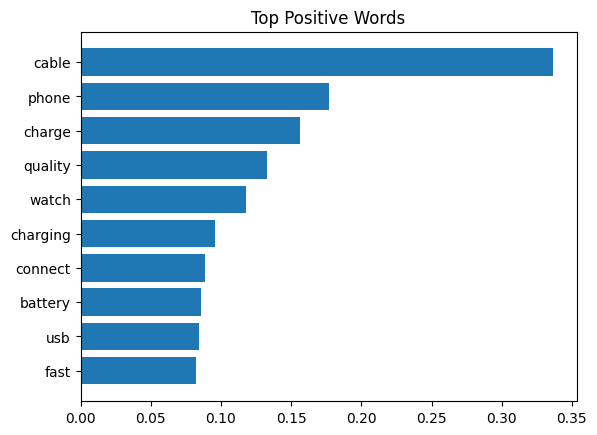

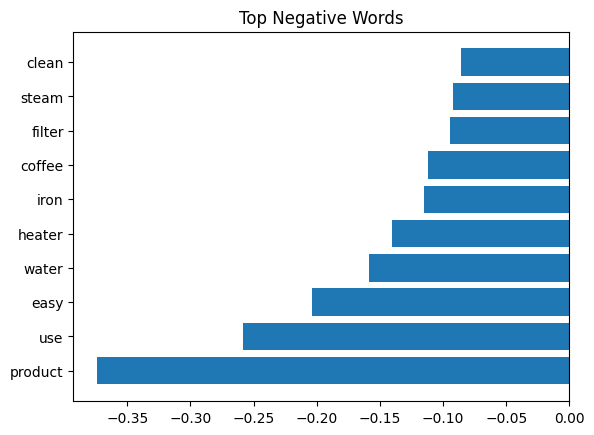

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

feature_names = vecotrizer.get_feature_names_out()
coeffs = lr.coef_[0]

# Top positive and negative words
top_pos_idx = np.argsort(coeffs)[-10:]
top_neg_idx = np.argsort(coeffs)[:10]

print("Top Positive Words:")
for i in top_pos_idx:
    print(feature_names[i], coeffs[i])

print("\nTop Negative Words:")
for i in top_neg_idx:
    print(feature_names[i], coeffs[i])

# Bar plots
plt.barh([feature_names[i] for i in top_pos_idx], coeffs[top_pos_idx])
plt.title("Top Positive Words")
plt.show()

plt.barh([feature_names[i] for i in top_neg_idx], coeffs[top_neg_idx])
plt.title("Top Negative Words")
plt.show()
